# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
titanic = pd.read_csv("./titanic.csv")

In [3]:
titanic.shape

(891, 12)

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

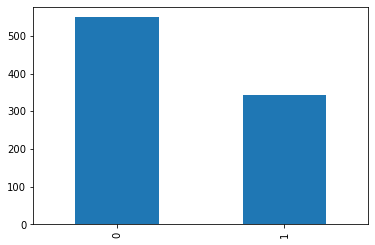

In [5]:
titanic["Survived"].value_counts().plot.bar()

# Preprocess data

In [6]:
X = titanic[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch"]]
y = titanic["Survived"]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((668, 6), (223, 6))

In [8]:
column_trans = ColumnTransformer(
    [
        ("Pclass", OneHotEncoder(dtype="int"), ["Pclass"]),
        ("Sex", OneHotEncoder(dtype="int"), ["Sex"]),
        ("Age", SimpleImputer(strategy="median"), ["Age"]),
        ("Fare", SimpleImputer(strategy="median"), ["Fare"]),
        ("SibSp", SimpleImputer(strategy="median"), ["SibSp"]),
        ("Parch", SimpleImputer(strategy="median"), ["Parch"]),
    ],
    remainder="drop",
).fit(X_train)
X_train = column_trans.transform(X_train)
X_val = column_trans.transform(X_val)

In [9]:
feature_names = []
for tr in column_trans.transformers_:
    if hasattr(tr[1], "get_feature_names"):
        features = [f"{tr[0]}_{c[3:]}" for c in tr[1].get_feature_names()]
        feature_names += features
    else:
        feature_names.append(tr[0])
feature_names

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Age',
 'Fare',
 'SibSp',
 'Parch']

# Must do One-Hot-Encode Category feature,
# For Explanation purpose.

In [10]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_val = pd.DataFrame(X_val, columns=feature_names)

In [11]:
X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,28.0,7.8958,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,17.0,7.9250,4.0,2.0
2,0.0,0.0,1.0,0.0,1.0,30.0,16.1000,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,22.0,7.2500,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,45.0,13.5000,0.0,0.0


In [12]:
X_val.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,29.0,14.4583,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,29.0,7.5500,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,7.0,29.1250,4.0,1.0
3,1.0,0.0,0.0,1.0,0.0,29.0,146.5208,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0,29.0,15.2458,0.0,2.0


# Train model

In [13]:
model = RandomForestClassifier(
    n_estimators=100, max_depth=3, random_state=0, class_weight="balanced"
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

In [14]:
y_val_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

In [15]:
val_auc = roc_auc_score(y_val, y_val_prob)
print(f"Val AUC={val_auc}")

Val AUC=0.8878040424803014


In [16]:
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Val ACC={val_acc}")

Val ACC=0.8026905829596412


(array([71., 30., 10., 31.,  3.,  4., 33.,  1.,  5., 35.]),
 array([0.16704545, 0.24541934, 0.32379323, 0.40216711, 0.480541  ,
        0.55891489, 0.63728878, 0.71566267, 0.79403655, 0.87241044,
        0.95078433]),
 <BarContainer object of 10 artists>)

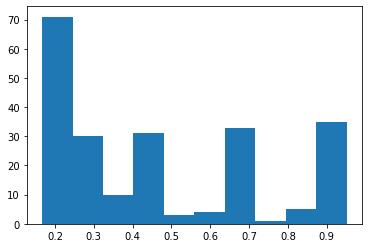

In [17]:
plt.hist(y_val_prob)

# Plot PDP

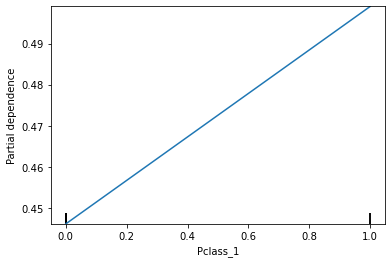

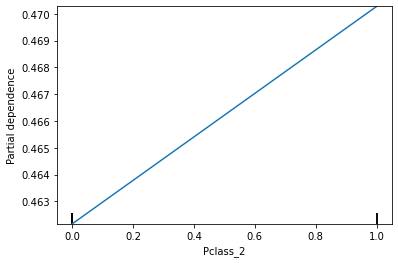

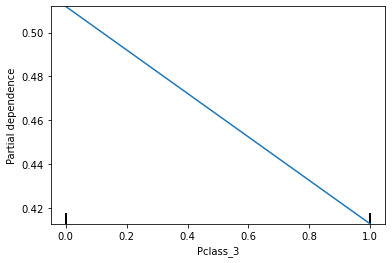

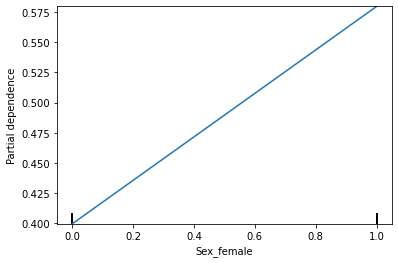

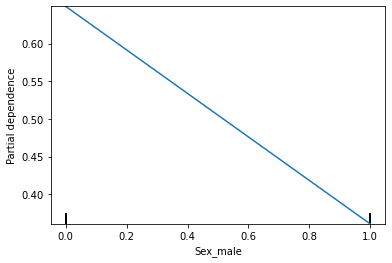

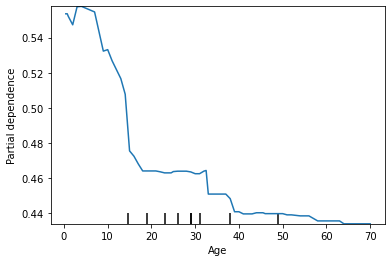

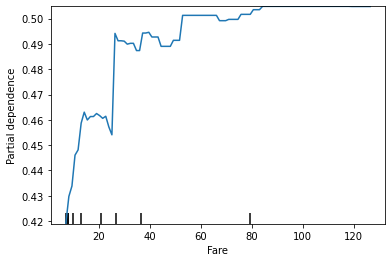

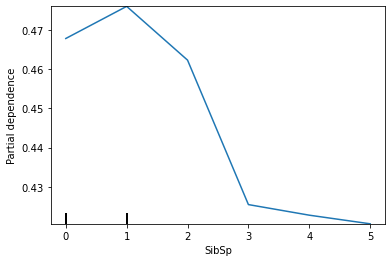

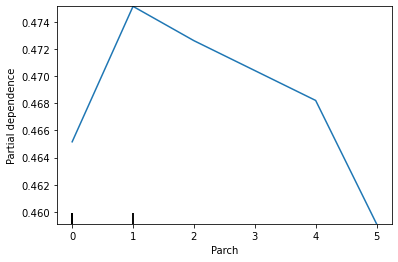

In [18]:
for feature in X_train.columns:
    plot_partial_dependence(model, X_val, [feature], response_method="predict_proba")

Dấu gạch dưới trục X: chỗ nào gạch nhiều thì chỗ đó # samples nhiều -> estimate tin cậy hơn.

# Extract PDP data

In [19]:
pdp, values = partial_dependence(
    model, X_val, ["Fare"], response_method="predict_proba"
)

In [20]:
pdp

array([[0.41892548, 0.42974392, 0.43383662, 0.4460412 , 0.44812666,
        0.45868939, 0.463026  , 0.45993422, 0.46129508, 0.46129508,
        0.46248412, 0.46167355, 0.46058967, 0.46140452, 0.45719503,
        0.4540792 , 0.49413786, 0.49122521, 0.49122521, 0.49106905,
        0.4898869 , 0.49021582, 0.49021582, 0.48735727, 0.48735727,
        0.49428067, 0.49428067, 0.49457402, 0.49271589, 0.49271589,
        0.49271589, 0.48902232, 0.48902232, 0.48902232, 0.48902232,
        0.49140021, 0.49140021, 0.49140021, 0.50126394, 0.50126394,
        0.50126394, 0.50126394, 0.50126394, 0.50126394, 0.50126394,
        0.50126394, 0.50126394, 0.50126394, 0.50126394, 0.50126394,
        0.49916243, 0.49916243, 0.49916243, 0.4996743 , 0.4996743 ,
        0.4996743 , 0.4996743 , 0.50165985, 0.50165985, 0.50165985,
        0.50165985, 0.50349585, 0.50349585, 0.50349585, 0.50481691,
        0.50481691, 0.50481691, 0.50481691, 0.50481691, 0.50481691,
        0.50481691, 0.50481691, 0.50481691, 0.50

In [21]:
values

[array([  7.05      ,   8.25535354,   9.46070707,  10.66606061,
         11.87141414,  13.07676768,  14.28212121,  15.48747475,
         16.69282828,  17.89818182,  19.10353535,  20.30888889,
         21.51424242,  22.71959596,  23.92494949,  25.13030303,
         26.33565657,  27.5410101 ,  28.74636364,  29.95171717,
         31.15707071,  32.36242424,  33.56777778,  34.77313131,
         35.97848485,  37.18383838,  38.38919192,  39.59454545,
         40.79989899,  42.00525253,  43.21060606,  44.4159596 ,
         45.62131313,  46.82666667,  48.0320202 ,  49.23737374,
         50.44272727,  51.64808081,  52.85343434,  54.05878788,
         55.26414141,  56.46949495,  57.67484848,  58.88020202,
         60.08555556,  61.29090909,  62.49626263,  63.70161616,
         64.9069697 ,  66.11232323,  67.31767677,  68.5230303 ,
         69.72838384,  70.93373737,  72.13909091,  73.34444444,
         74.54979798,  75.75515152,  76.96050505,  78.16585859,
         79.37121212,  80.57656566,  81.

Text(0, 0.5, 'Avg Probability')

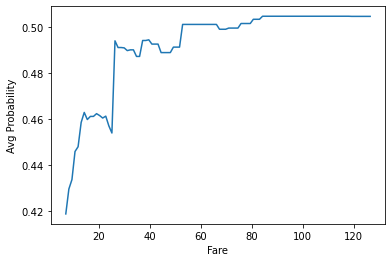

In [22]:
fig, ax = plt.subplots()
ax.plot(values[0].ravel(), pdp.ravel())
ax.set_xlabel("Fare")
ax.set_ylabel("Avg Probability")